# Classifying News Article Bias with LSTM

In [1]:
import sqlite3
import pickle
import numpy as np
import re
import random
from time import strftime, localtime

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
MAX_ARTICLE_LENGTH = 10000
PAD_VALUE = 0

db = sqlite3.connect('text_encoder.db')
c = db.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS "TextEncoder"(
    "word" TEXT,
    "n" INTEGER,
    PRIMARY KEY("word")
);''')
del c

In [3]:
def get_max_key():
    c = db.cursor()
    c.execute('SELECT MAX(n) FROM TextEncoder;')
    return c.fetchone()[0]

def add_word_encoding(word, key):
    c = db.cursor()
    c.execute('INSERT INTO TextEncoder (word, n) VALUES (?, ?);', (word, key))
    assert c.rowcount > 0, "ERROR Inserting key %10s as word: %20s" % (key, word)
    db.commit()
    return

def get_word_key(word, freeze):
    c = db.cursor()
    c.execute('SELECT n FROM TextEncoder WHERE word = ?;', (word,))
    response = c.fetchone()
    if response is not None:
        return response[0]
    else:
        if freeze:
            return None
        else:
            key = get_max_key() + 1
            add_word_encoding(word, key)
            print('Adding word "%20s" as n: %10i' % (word, key))
            return key

def get_vocab_length():
    c = db.cursor()
    c.execute('SELECT COUNT(*) FROM TextEncoder;')
    return c.fetchone()[0]

def numberize_article(article, freeze):
    tokens = text_to_word_sequence(article)
    num_article = []
    for token in tokens:
        key = get_word_key(token, freeze)
        if key is not None:
            num_article.append(key)
    return np.array(num_article)

def get_nums_word(n):
    c = db.cursor()
    c.execute('SELECT word FROM TextEncoder WHERE n = ?;', (n,))
    word = c.fetchone()
    if word is None:
        return ''
    else:
        return word[0]

In [4]:
def remake_article(num_article):
    text_array = [get_nums_word(n) for n in num_article]
    raw_text = ' '.join(text_array)
    return re.sub(r'\s+', ' ', raw_text)


def parse_articles(articles, max_length=MAX_ARTICLE_LENGTH, min_length=20, verbose=False, freeze=False):
    numerified_articles = []
    removed_articles = set()
    for i, a in enumerate(articles):
        numberized = numberize_article(a, freeze)
        if len(numberized) >= min_length:
            numerified_articles.append(numberized)
        else:
            removed_articles.add(i)
            if verbose:
                print('Removing article: %6i for being too short. Length: %3i' % (i, len(numberized)))
    numerified_articles = np.array(numerified_articles)
    return pad_sequences(numerified_articles, maxlen=max_length, dtype='float32', value=0), removed_articles


def train_test_split(data_in, data_out, train_pct=0.75, validate=True, val_pct_of_test=0.33):
    all_data = list(zip(data_in, data_out))
    random.shuffle(all_data)
    shuffled_in, shuffled_out = zip(*all_data)
    data_length = len(all_data)
    if validate:
        test_split = int(data_length * train_pct)
        val_split = test_split + int((data_length - test_split) * (1 - val_pct_of_test))
        
        train_in = shuffled_in[:test_split]
        test_in = shuffled_in[test_split:val_split]
        val_in = shuffled_in[val_split:]
        
        train_out = shuffled_out[:test_split]
        test_out = shuffled_out[test_split:val_split]
        val_out = shuffled_out[val_split:]
        
        return (np.array(train_in), np.array(train_out)), (np.array(val_in), np.array(val_out)), (np.array(test_in), np.array(test_out))
    else:
        test_split = int(data_length * train_pct)
        train_in = shuffled_in[:test_split]
        train_out = shuffled_out[:test_split]
        test_in = shuffled_in[test_split:]
        test_out = shuffled_out[test_split:]
        return (np.array(train_in), np.array(train_out)), (np.array(test_in), np.array(test_out))


def create_model(encoding_vector_size=100, n_filters=32, kernel_size=3, pool_size=2, add_dropout=True, dropout_pct=0.2):
    model = Sequential()
    model.add(Embedding(
        input_dim=get_vocab_length(),
        output_dim=encoding_vector_size,
        input_length=MAX_ARTICLE_LENGTH
    ))
    if add_dropout:
        model.add(Dropout(dropout_pct))
    model.add(Conv1D(
        filters=n_filters, 
        kernel_size=kernel_size, 
        padding='same', 
        activation='relu'
    ))
    model.add(MaxPooling1D(
        pool_size=pool_size
    ))
    if add_dropout:
        model.add(Dropout(dropout_pct))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    return model

def gen_filename():
    return 'savedModels/article_lstm_model_%s.h5' % strftime('%y%m%d.%H%M%S', localtime())

def get_data_from_db():
    adb = sqlite3.connect('articles.db')
    c = adb.cursor()
    c.execute('SELECT text, right_score FROM SiteScrape;')
    articles, labels = zip(*c.fetchall())
    return articles, np.array(labels).astype('float32')

def save_data(articles, labels):
    data = {
        'articles': articles,
        'labels': labels
    }
    with open('data_save.pickle', 'wb') as f:
        pickle.dump(data, f)
    return

def get_data_from_pickle():
    with open('data_save.pickle', 'rb') as f:
        data = pickle.load(f)
    articles = data['articles']
    labels   = data['labels']
    return articles, labels

Import the data, parse the articles & labels, and then save them out

In [5]:
# Load
articles, labels = get_data_from_db()

# Process
processed_articles, removed_articles = parse_articles(articles)
labels = np.array([l for i, l in enumerate(labels) if i not in removed_articles])

#Save
save_data(processed_articles, labels)

*Then* next time you can just load in the already processed data… (assuming nothing has changed)

In [6]:
processed_articles, labels = get_data_from_pickle()

Split out the data into `train`, `validate`, and`test`

In [7]:
(train_in, train_out), (val_in, val_out), (test_in, test_out) = train_test_split(processed_articles, labels)

Now build the model…

In [8]:
model = create_model()

callbacks = [
    EarlyStopping(
        monitor='val_acc', 
        patience=2
    ),
    ModelCheckpoint(
        filepath=gen_filename(), 
        monitor='val_acc', 
        save_best_only=True
    )
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


What does the model look like?

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10000, 100)        17328600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000, 100)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10000, 32)         9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5000, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5000, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total para

Not starting from scratch? Use the following code instead

In [5]:
# Enter the filename of the model to load
model_filename = 'savedModels/article_lstm_model_190515.002419.h5'
model = load_model(model_filename)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train the model for 3 epochs

In [ ]:
hist = model.fit(
    train_in,
    train_out,
    epochs=5,
    batch_size=64,
    validation_data=(val_in, val_out),
    callbacks=callbacks
)

Train on 13912 samples, validate on 1531 samples
Epoch 1/5


Evaluate the trained model…

In [29]:
evaluate = model.evaluate(test_in, test_out)
print('History Results:')
print('Loss:     %5.2f\nAccuracy: %5.2f %%' % (evaluate[0], (evaluate[1]*100)))

3107/3107 [==============================] - 71s 23ms/step
History Results:
Loss:      0.05
Accuracy: 97.88 %


Plot the history

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

What does the accuracy look like?

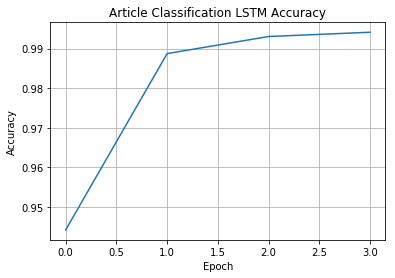

In [31]:
plt.plot(hist.history['acc'])
plt.title('Article Classification LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


What does the loss look like?

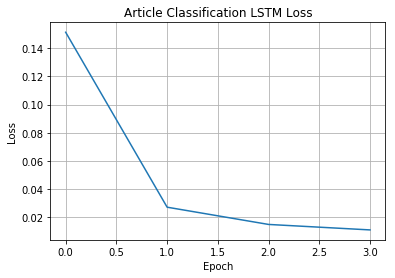

In [32]:
plt.plot(hist.history['loss'])
plt.title('Article Classification LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()


## Testing the Network

In [6]:
import re
import requests
from bs4 import BeautifulSoup
from keras.models import load_model

In [7]:
model = load_model('savedModels/article_lstm_model_190515.002419.h5')

In [8]:
def clean_text(raw_text, to_lower=True):
    text = re.sub(r'(https|http):[^\s]*', ' ', raw_text)
    text = re.sub('[' + re.escape('#@!"$%&(\')*+,-./:;<=>?[\\]^_`{|}~') + ']', '', text)
    text = text.encode('utf8').decode('ascii','ignore')
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text.lower()

def scrape_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, features='lxml')
    p_tags = soup.find_all('p')
    raw_text = ' '.join([p.text for p in p_tags])
    text = clean_text(raw_text)
    return text

def make_prediction(text, model=model):
    parsed_article, _ = parse_articles([text], min_length=10, freeze=True)
    if len(parsed_article) < 1:
        print('Sorry! It looks like once I processed that article, it was too short to use. :\'(')
        return
    print('🤔 Let me think…')
    prediction = model.predict(parsed_article)
    prediction_pct = prediction[0] * 100
    print('''\n   ------------------------------------------------------------------------------------------\n  |   I\'d say that there\'s a %5.2f%% chance that your article is from a right-leaning source. |\n  |  ----------------------------------------------------------------------------------------\n  |/\n🖥️\n''' % prediction_pct)
    return

Enter a URL below to test out the model!

In [10]:
url = input('Enter a url: ').strip()
print('\n\n')
make_prediction(url)

Enter a url:  https://www.breitbart.com/politics/2019/10/20/sheriff-my-deputies-wont-be-in-beto-orourkes-anti-gun-gestapo/





🤔 Let me think…

   ------------------------------------------------------------------------------------------
  |   I'd say that there's a 98.93% chance that your article is from a right-leaning source. |
  |  ----------------------------------------------------------------------------------------
  |/
🖥️

